## Quantum Phase Estimation (3-bit)

In [1]:
PRECISION = 3

In [2]:
from qiskit.circuit.library import SGate, ZGate

# get unitary matrix representation of S gate
U_matrix = SGate().to_matrix()
print(U_matrix)

[[1.+0.j 0.+0.j]
 [0.+0.j 0.+1.j]]


In [3]:
# create a list of matrices of U, U^2, U^4, U^8, ...
U_power = U_matrix
U_power_list = [U_power]
for _ in range(1, PRECISION):
  U_power = U_power @ U_power
  U_power_list.append(U_power)

In [4]:
U_power_list[2]

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

In [5]:
from qiskit.extensions import UnitaryGate

# create a list of controlled gates of U, U^2, U^4, U^8, ...
U_gate_list = [
  UnitaryGate(m, label=f'U^{2**i}').control() 
  for i, m in enumerate(U_power_list)
]

In [10]:
from qiskit.circuit.library import QFT

# get IQFT circuit
iqft_circuit = QFT(PRECISION, inverse=True)

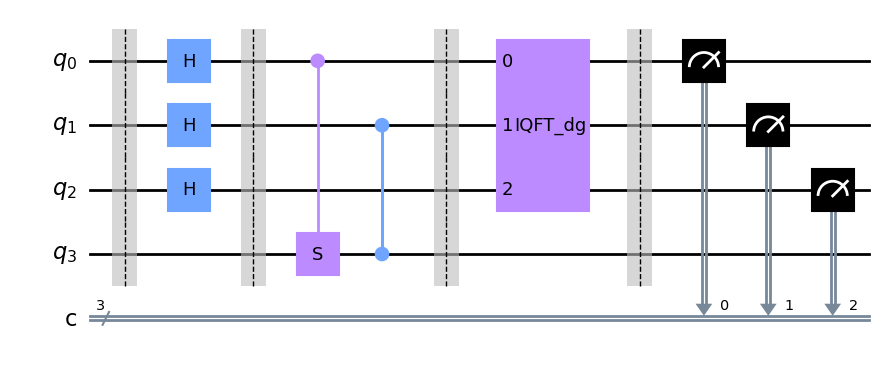

In [11]:
from qiskit import QuantumCircuit

# Create QPE circuit:
ancilla = list(range(PRECISION))
eigenstate = PRECISION

qc = QuantumCircuit(PRECISION + 1, PRECISION)
# qc.x(eigenstate)  # v = \ket{1}
qc.barrier()
qc.h(ancilla)
qc.barrier()
qc.append(SGate().control(), [0, eigenstate])
qc.append(ZGate().control(), [1, eigenstate])
qc.barrier()
qc.compose(iqft_circuit, ancilla, inplace=True)
qc.barrier()
qc.measure(ancilla, ancilla)

qc.draw('mpl')

## Simulator

In [8]:
from qiskit_ionq import IonQProvider
provider = IonQProvider("your_private_token")

In [16]:
qc = QuantumCircuit(2)
qc.cu(1, 2, 3, 4, 0, 1)

In [19]:
from qiskit import transpile, Aer

simulator_backend = Aer.get_backend('aer_simulator')
sim_qc = transpile(qc, basis_gates=['u1', 'u2', 'u3', 'cx'])

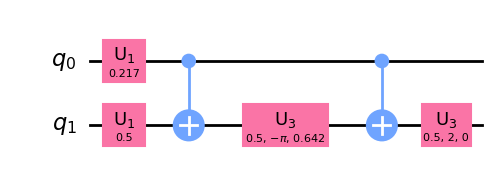

In [20]:
sim_qc.draw('mpl')

In [15]:
# Run the circuit on IonQ's platform:
job = simulator_backend.run(sim_qc, shots=10000)

# Print the counts
print(job.result().get_counts())

{'000': 10000}


## QPU

In [12]:
qpu_backend = provider.get_backend("ionq_qpu")
qpu_qc = transpile(qc, qpu_backend)

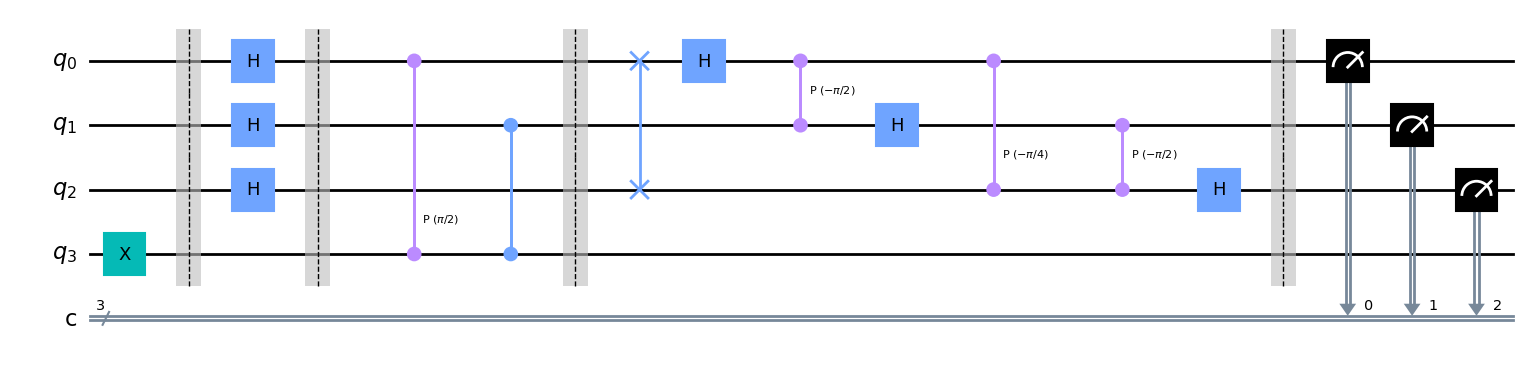

In [13]:
qpu_qc.draw('mpl')

In [14]:
qpu_job = qpu_backend.run(qpu_qc, shots=10000)

In [15]:
from qiskit.providers.jobstatus import JobStatus
import time

while qpu_job.status() is not JobStatus.DONE:
	print("Job status is", qpu_job.status() )
	time.sleep(60)
print("Job status is", qpu_job.status() )

# Print the counts
print(qpu_job.get_counts()) 

Job status is JobStatus.INITIALIZING
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.DONE
{'000': 658, '001': 171, '010': 7108, '011': 560, '100': 463, '101': 138, '110': 649, '111': 253}


QPU Output
```
{'000': 658, '001': 171, '010': 7108, '011': 560, '100': 463, '101': 138, '110': 649, '111': 253}
```

## Result

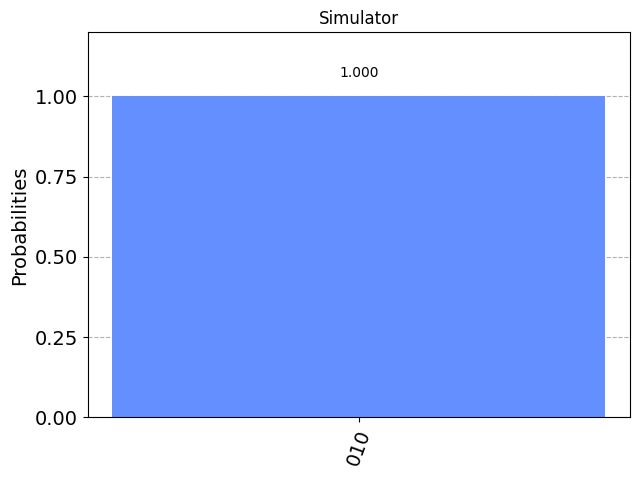

In [16]:
import matplotlib.pyplot as plt
from qiskit.tools.visualization import plot_histogram

plot_histogram(job.get_counts(), title='Simulator')

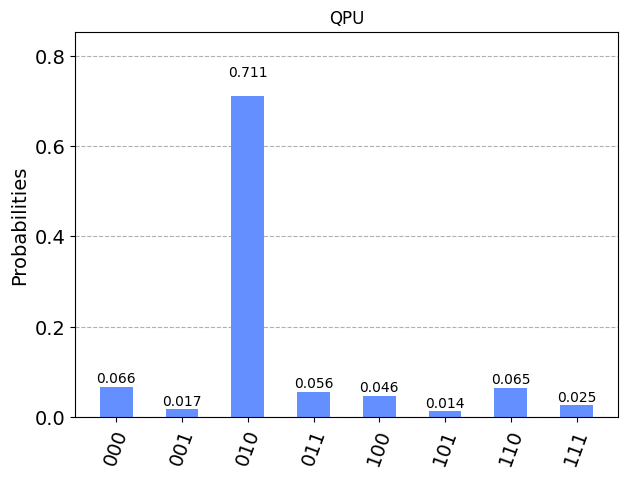

In [17]:
plot_histogram(qpu_job.get_counts(), title='QPU')